In [1]:
from scipy.spatial.distance import cdist
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import pandas as pd
import numpy as np
import gc
import psutil
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from hdbscan import HDBSCAN
import fastcluster
from scipy.cluster.hierarchy import fcluster
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import silhouette_score

# Uyarıları bastırma
warnings.filterwarnings("ignore")

In [2]:
# CPU Zaman Ölçüm Fonksiyonu
def measure_cpu_time():
    process = psutil.Process()
    return process.cpu_times().user

In [3]:
# Veri yükleme
data = pd.read_csv("customer_shopping_data_copy3.csv")

# Gerekli sütunları seçme
selected_columns = ["shopping_mall", "category", "quantity"]
data = data[selected_columns]

# Belleği temizleme
gc.collect()

0

In [4]:
# Kategorik değişkenleri sayısal hale getirme
data_encoded = pd.get_dummies(data, drop_first=True)

# Veriyi normalize etme
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_encoded)

# Belleği temizleme
gc.collect()

0

In [5]:
# MiniBatch K-Means için Hiper Parametre Optimizasyonu
start_time = measure_cpu_time()
kmeans = MiniBatchKMeans(random_state=42)
param_dist_kmeans = {'n_clusters': [3, 5], 'batch_size': [100]}
kmeans_search = RandomizedSearchCV(kmeans, param_distributions=param_dist_kmeans, n_iter=2, cv=2)
kmeans_search.fit(scaled_data)
kmeans_labels = kmeans_search.best_estimator_.predict(scaled_data)
kmeans_cpu_time = measure_cpu_time() - start_time
print('Best Parameters for MiniBatch K-Means:', kmeans_search.best_params_)

Best Parameters for MiniBatch K-Means: {'n_clusters': 5, 'batch_size': 100}


In [6]:
# HDBSCAN için Hiper Parametre Optimizasyonu
start_time = measure_cpu_time()
param_dist_hdbscan = {'min_cluster_size': [10], 'min_samples': [3,5]}
optimal_hdbscan = HDBSCAN(min_cluster_size=param_dist_hdbscan['min_cluster_size'][0],
                          min_samples=param_dist_hdbscan['min_samples'][0])
hdbscan_labels = optimal_hdbscan.fit_predict(scaled_data)
hdbscan_cpu_time = measure_cpu_time() - start_time
print('Best Parameters for HDBSCAN:', param_dist_hdbscan)

Best Parameters for HDBSCAN: {'min_cluster_size': [10], 'min_samples': [5]}


In [7]:
# FastCluster için Hiper Parametre Optimizasyonu
start_time = measure_cpu_time()
best_cluster_number = None
best_silhouette_score = -1
for cluster_number in [3, 5]:
    linkage_matrix = fastcluster.linkage_vector(scaled_data, method="ward")
    clusters_temp = fcluster(linkage_matrix, t=cluster_number, criterion='maxclust')
    if len(set(clusters_temp)) > 1:
        silhouette_avg = silhouette_score(scaled_data, clusters_temp)
        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_cluster_number = cluster_number
clusters = fcluster(linkage_matrix, t=best_cluster_number, criterion='maxclust')
fastcluster_cpu_time = measure_cpu_time() - start_time
print('Best Parameters for FastCluster: Number of Clusters =', best_cluster_number)

Best Parameters for FastCluster: Number of Clusters = 5


In [8]:
def calculate_metrics(data, labels, model, algorithm_name, cpu_time=None):
    # Negatif etiketleri filtrele (örneğin HDBSCAN -1 kullanır)
    filtered_labels = labels[labels >= 0]  # Negatif etiketleri çıkar
    cluster_sizes = np.bincount(filtered_labels)
    cluster_size_variance = np.var(cluster_sizes)
    
    metrics = {
        'Algorithm': algorithm_name,
        'CPU Time (s)': cpu_time,  # CPU Time parametre olarak eklendi
        'Silhouette Score': silhouette_score(data, labels) if len(set(filtered_labels)) > 1 else None,
        'Number of Clusters': len(set(filtered_labels)),
        'Total Data Size': data.shape[0],
        'Davies-Bouldin Index': davies_bouldin_score(data, labels) if len(set(filtered_labels)) > 1 else None,
        'Calinski-Harabasz Index': calinski_harabasz_score(data, labels) if len(set(filtered_labels)) > 1 else None,
        'Cluster Size Variance': cluster_size_variance
    }

    # K-Means için özel metrikler
    if algorithm_name == 'MiniBatch K-Means':
        metrics['WSS (Within Sum of Squares)'] = sum(np.min(cdist(data, model.cluster_centers_, 'euclidean'), axis=1))
        metrics['Inertia'] = model.inertia_
    else:
        metrics['WSS (Within Sum of Squares)'] = None
        metrics['Inertia'] = None

    # Metrikleri yazdırma
    print(f"\n--- {algorithm_name} Metrics ---")
    for key, value in metrics.items():
        print(f"{key}: {value}")

    return metrics

# Her algoritma için metrik hesaplama ve yazdırma
kmeans_metrics = calculate_metrics(scaled_data, kmeans_labels, kmeans_search.best_estimator_, 'MiniBatch K-Means', kmeans_cpu_time)
hdbscan_metrics = calculate_metrics(scaled_data, hdbscan_labels, optimal_hdbscan, 'HDBSCAN', hdbscan_cpu_time)
fastcluster_metrics = calculate_metrics(scaled_data, clusters, None, 'Fastcluster', fastcluster_cpu_time)

# Performans metriklerini DataFrame olarak görüntüleme
performance_metrics = pd.DataFrame([kmeans_metrics, hdbscan_metrics, fastcluster_metrics])

# Performans metriklerini yazdırma
print("\n--- Performance Metrics DataFrame ---")
print(performance_metrics)


--- MiniBatch K-Means Metrics ---
Algorithm: MiniBatch K-Means
CPU Time (s): 0.7471621119999998
Silhouette Score: 0.18753176963732007
Number of Clusters: 5
Total Data Size: 15429
Davies-Bouldin Index: 2.056946709670394
Calinski-Harabasz Index: 1452.7569390362269
Cluster Size Variance: 2422217.36
WSS (Within Sum of Squares): 51936.572266908006
Inertia: 190776.49364788277

--- HDBSCAN Metrics ---
Algorithm: HDBSCAN
CPU Time (s): 6.107296768
Silhouette Score: 0.9766629252112854
Number of Clusters: 351
Total Data Size: 15429
Davies-Bouldin Index: 0.8868902102040159
Calinski-Harabasz Index: 6994.7538050536
Cluster Size Variance: 1690.2491051209004
WSS (Within Sum of Squares): None
Inertia: None

--- Fastcluster Metrics ---
Algorithm: Fastcluster
CPU Time (s): 10.964333568
Silhouette Score: 0.26262292105431595
Number of Clusters: 5
Total Data Size: 15429
Davies-Bouldin Index: 1.33394231094074
Calinski-Harabasz Index: 1238.4270337328767
Cluster Size Variance: 19517068.25
WSS (Within Sum of S

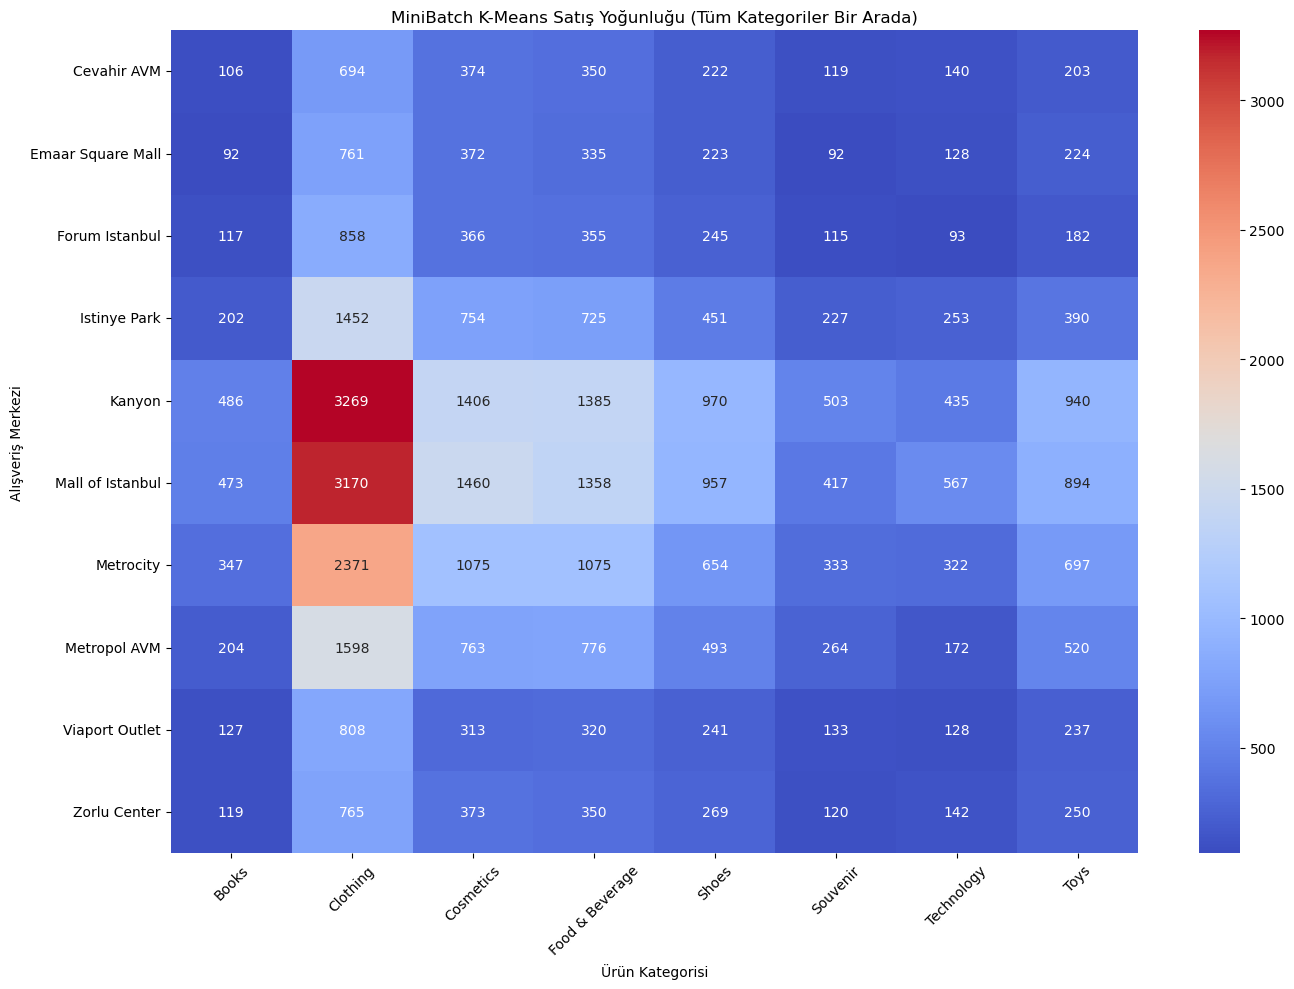

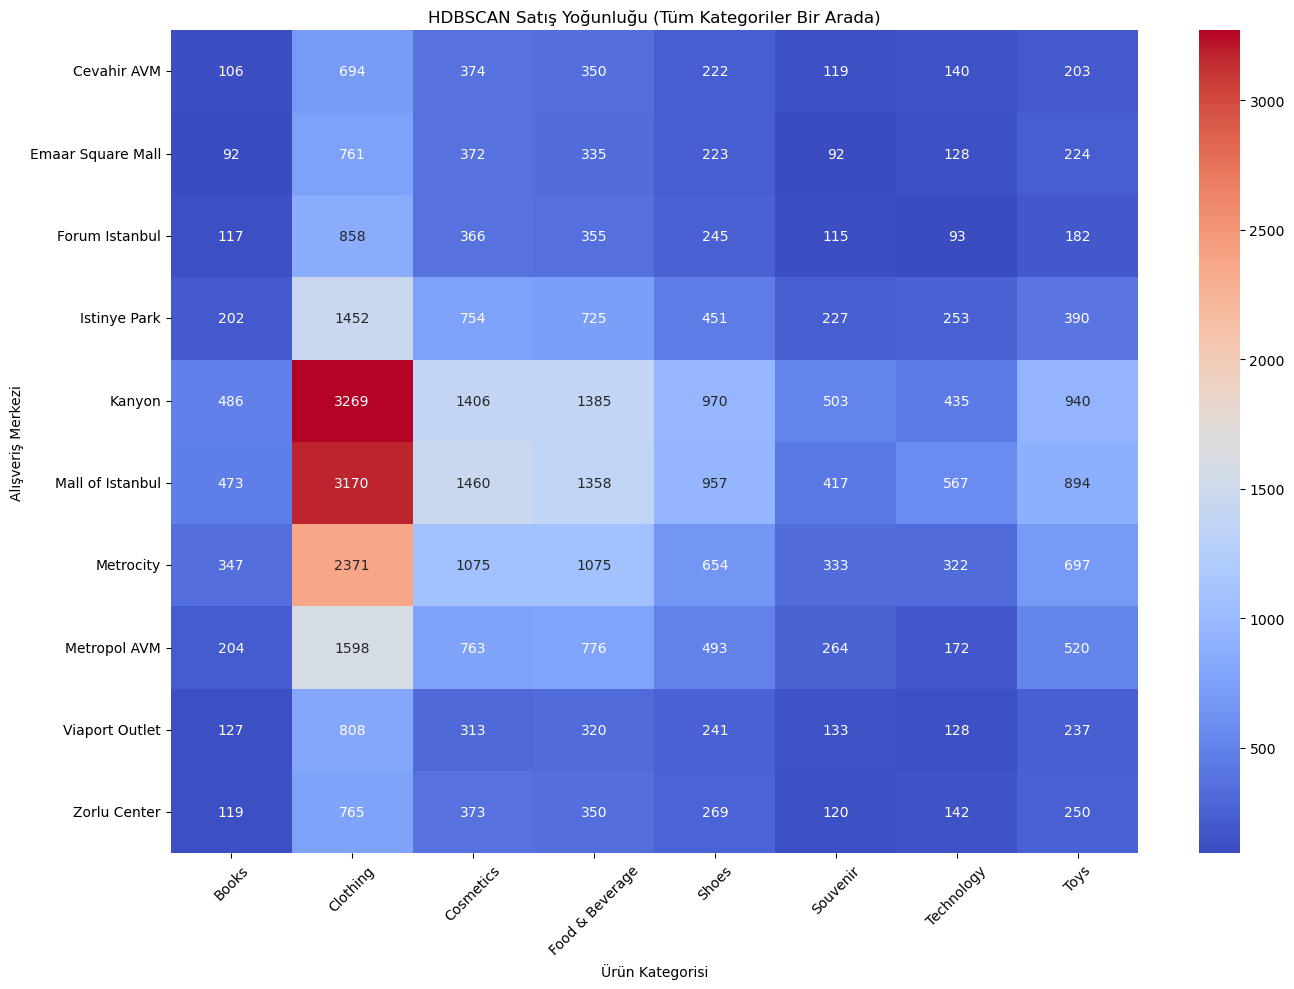

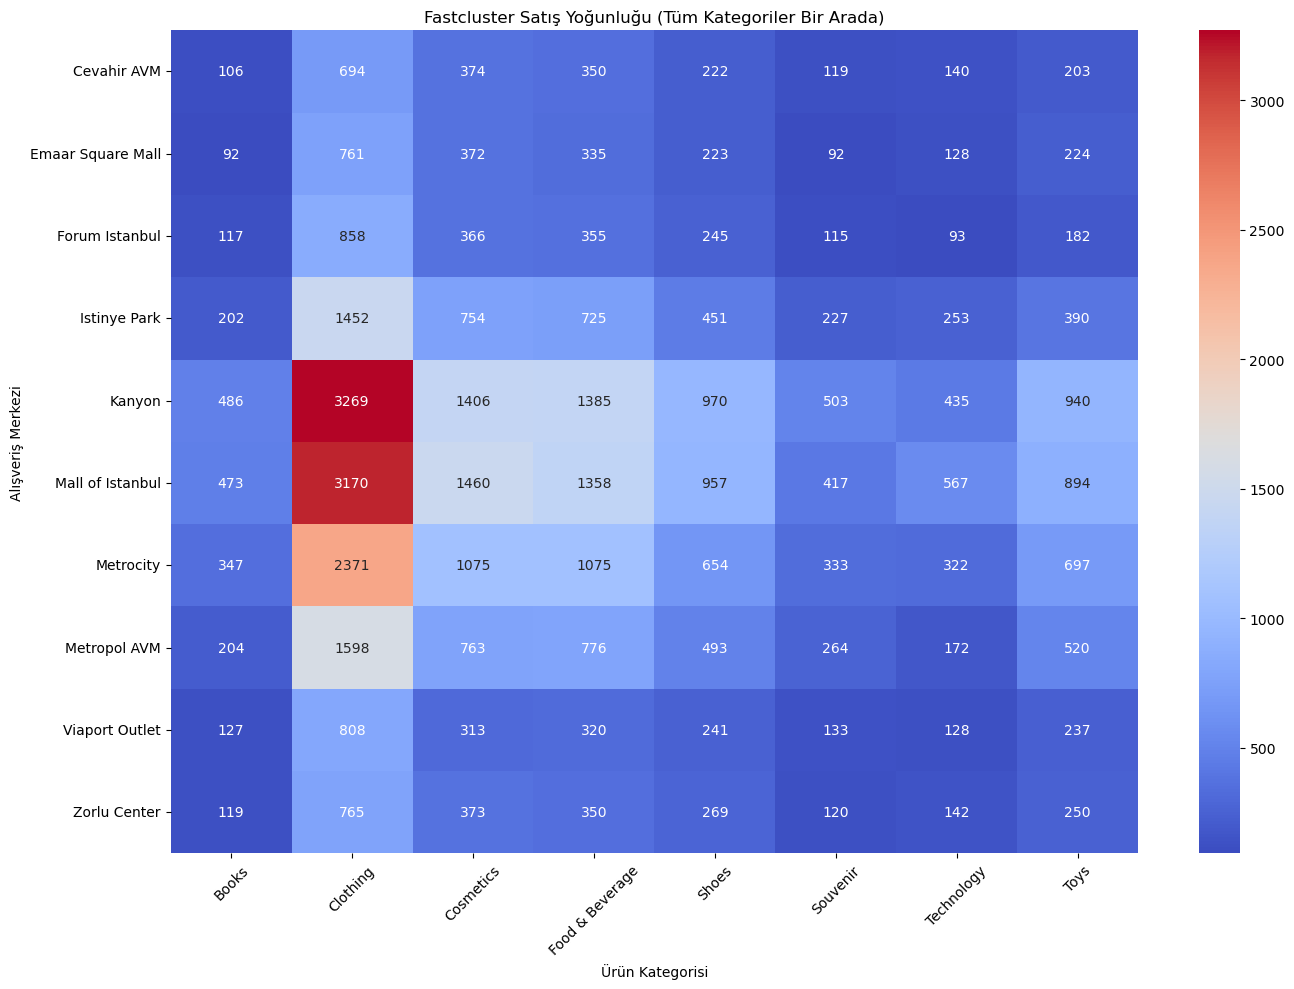

In [9]:
# Algoritma Bazlı Satış Yoğunluğu Tablosu (Her Algoritma İçin Ayrı Grafik, Tüm Kategoriler Bir Arada)
for algorithm, labels in zip(["MiniBatch K-Means", "HDBSCAN", "Fastcluster"], [kmeans_labels, hdbscan_labels, clusters]):
    # Kopya veri seti ve etiketleme
    sales_heatmap = data.copy()
    sales_heatmap["cluster"] = labels

    # Tüm alışveriş merkezleri ve kategoriler için satış yoğunluğu
    sales_heatmap_grouped = sales_heatmap.pivot_table(values="quantity", index="shopping_mall", columns="category", aggfunc="sum", fill_value=0)

    # Grafik çizimi: Algoritma bazlı, tüm kategorileri içeren tek grafik
    plt.figure(figsize=(14, 10))
    sns.heatmap(sales_heatmap_grouped, annot=True, fmt=".0f", cmap="coolwarm")
    plt.title(f"{algorithm} Satış Yoğunluğu (Tüm Kategoriler Bir Arada)")
    plt.xlabel("Ürün Kategorisi")
    plt.ylabel("Alışveriş Merkezi")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

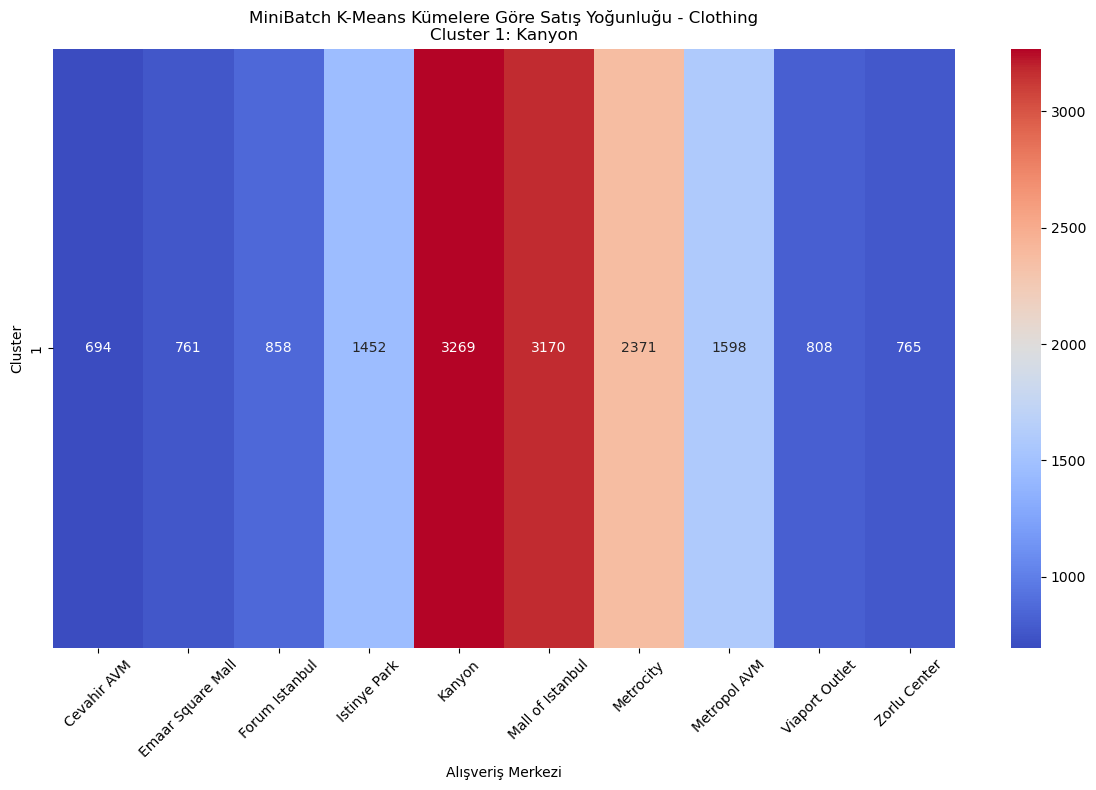

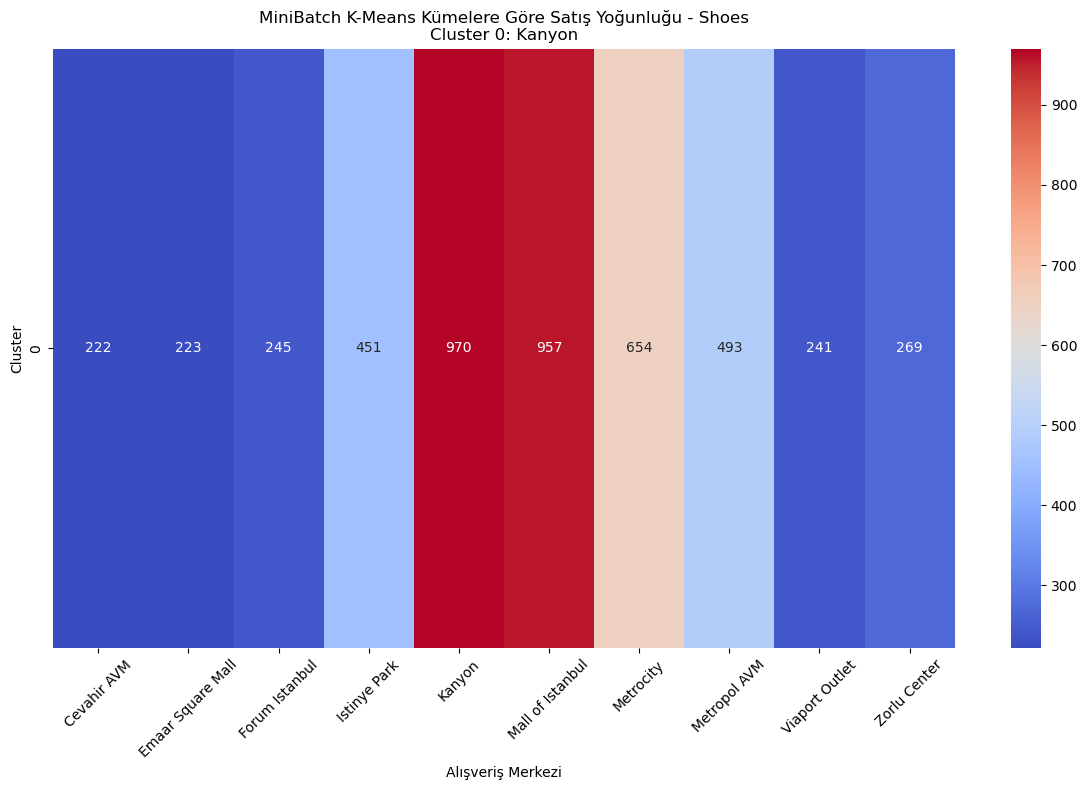

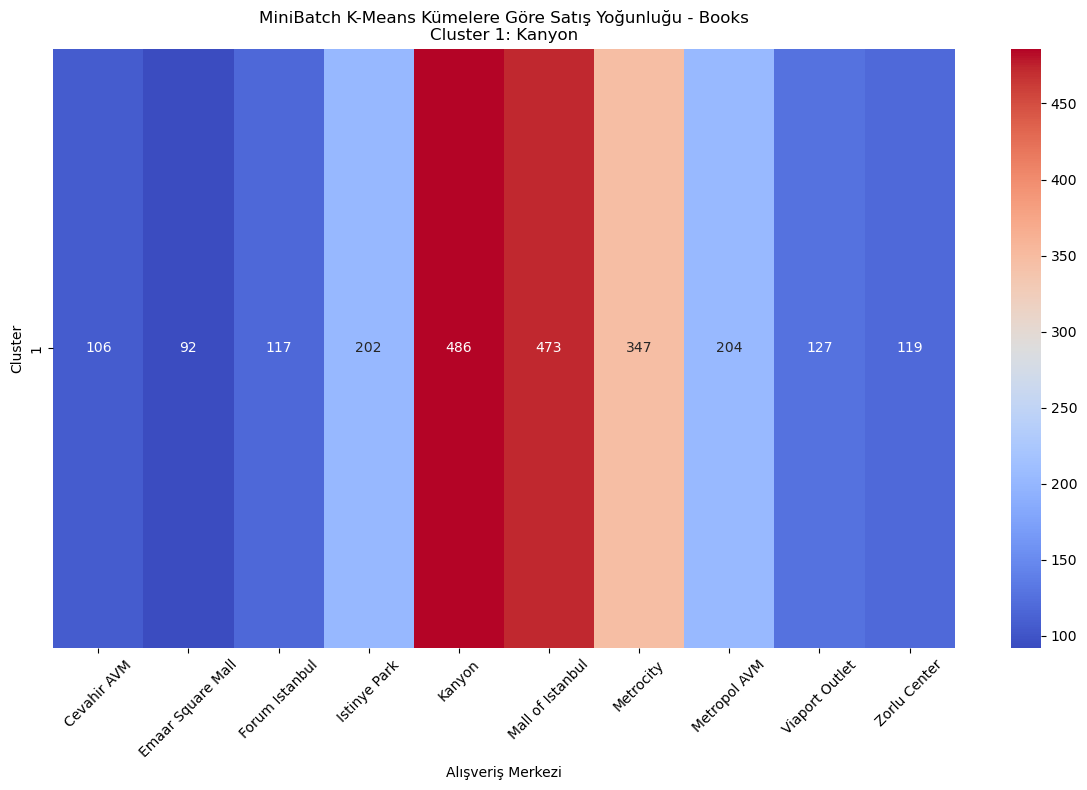

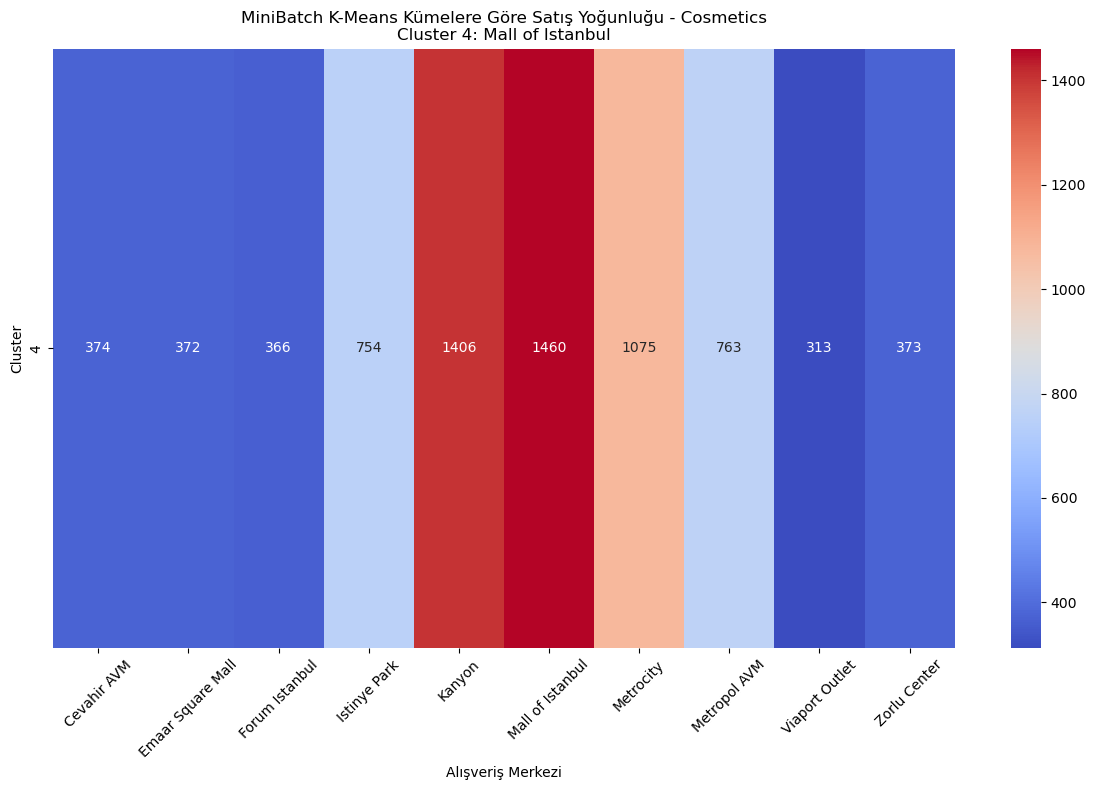

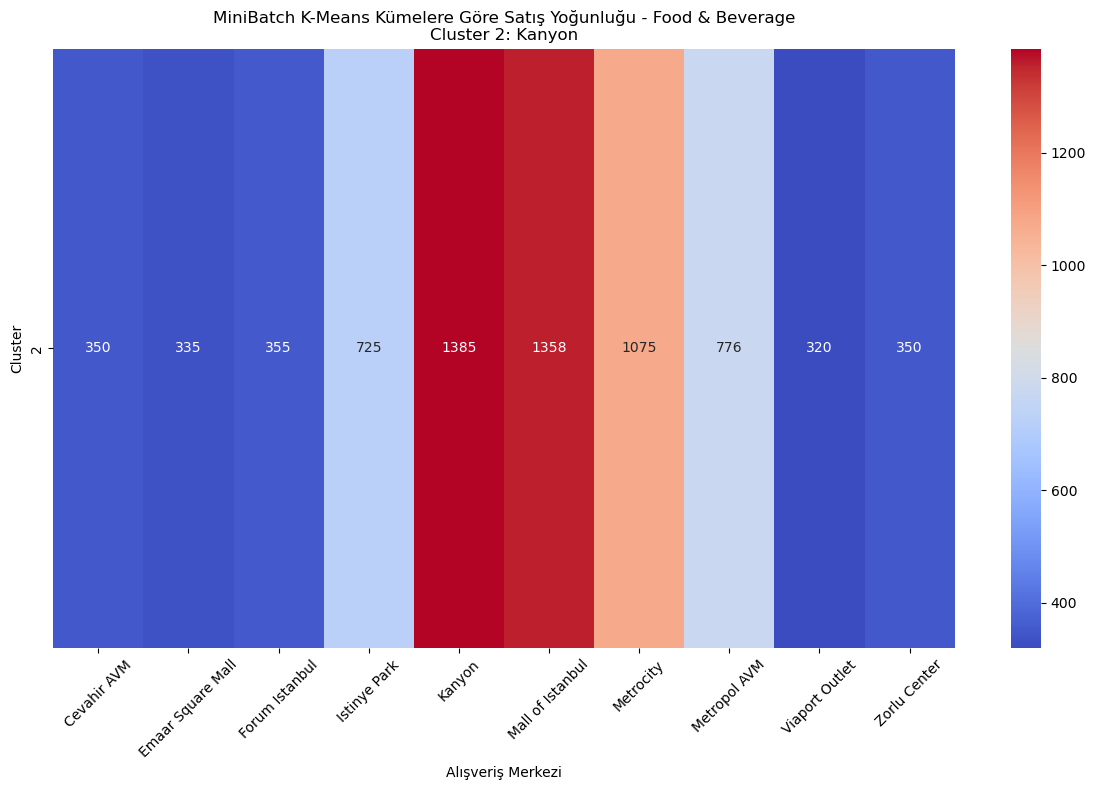

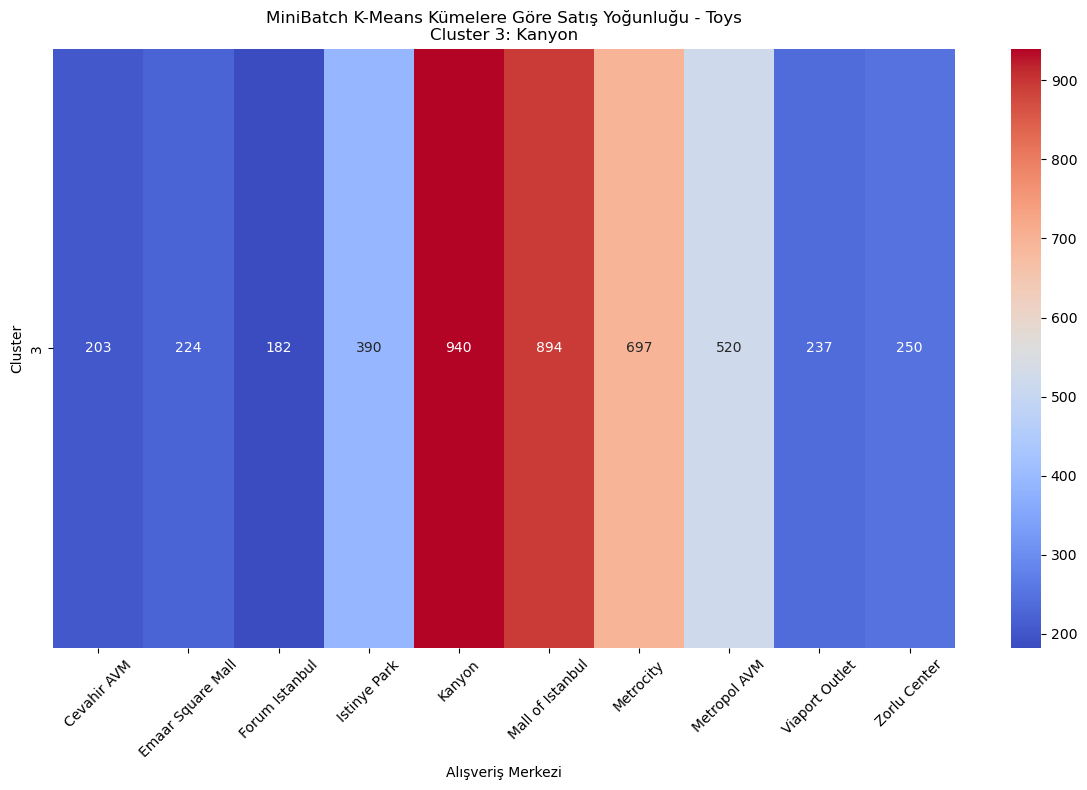

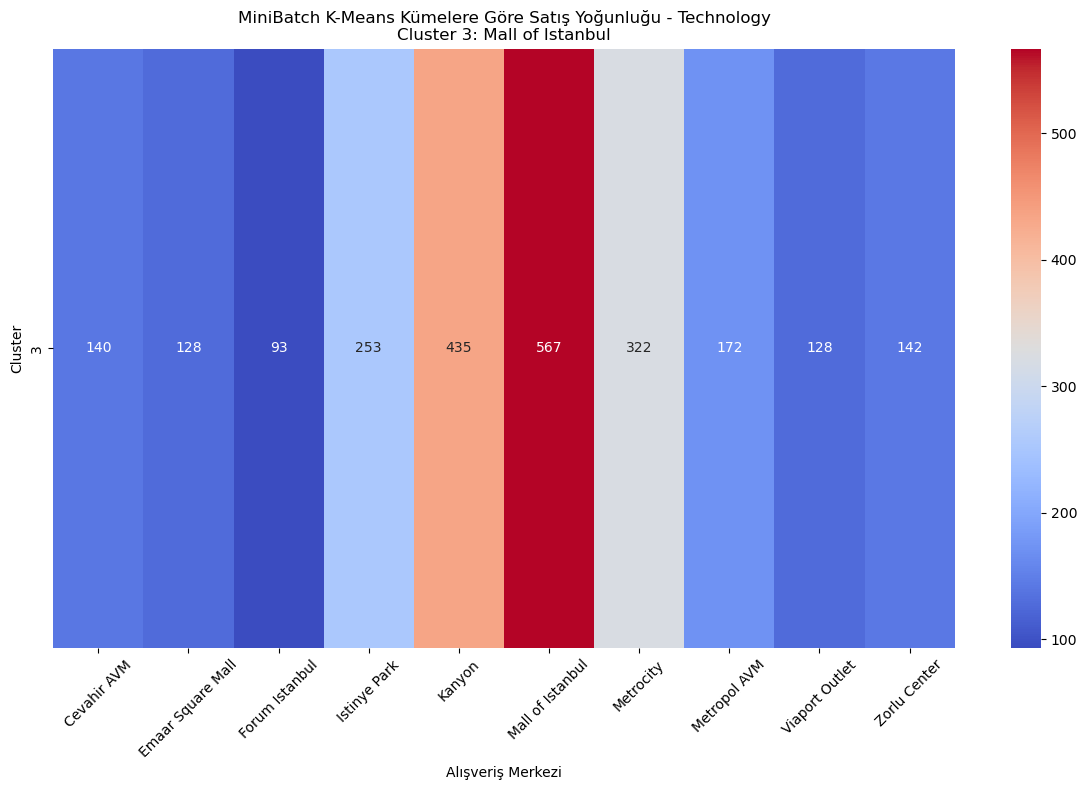

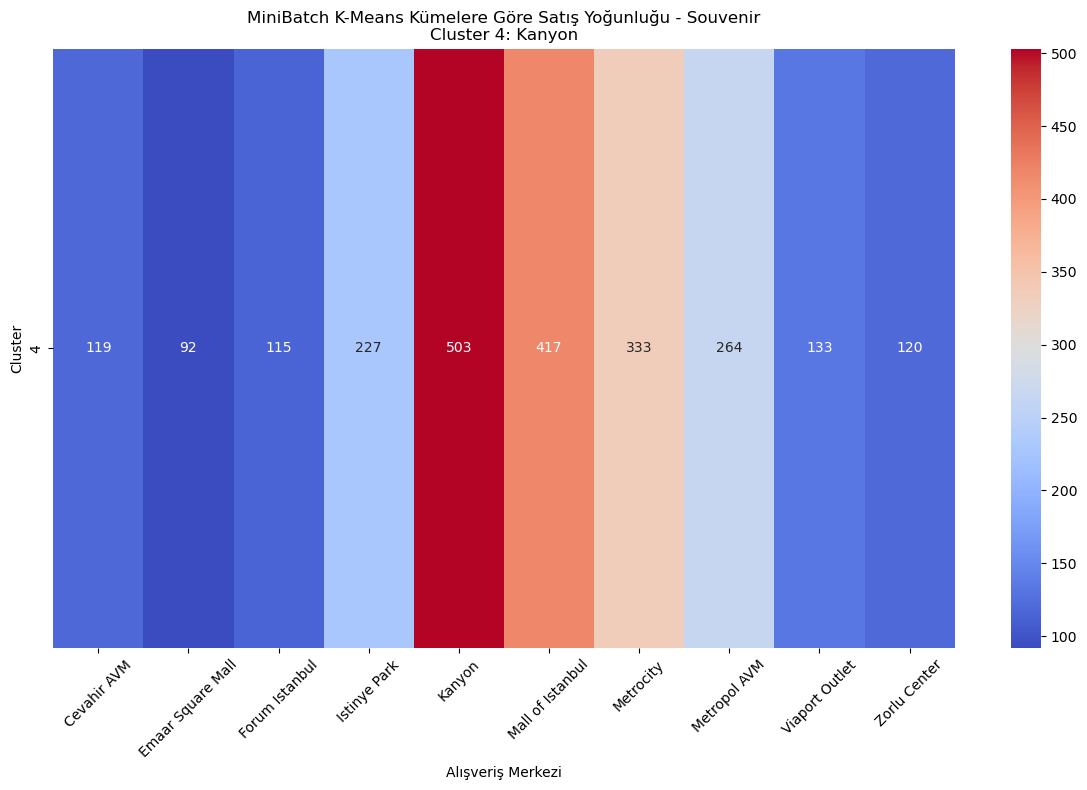

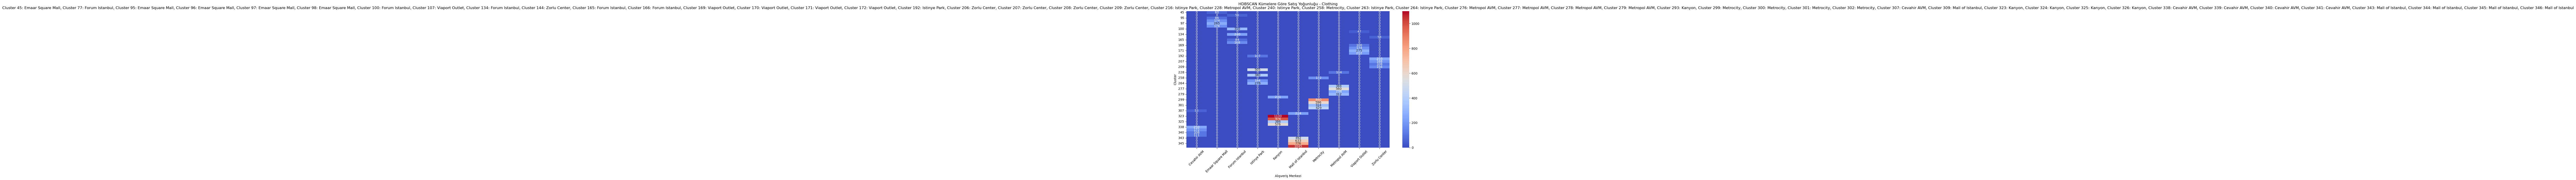

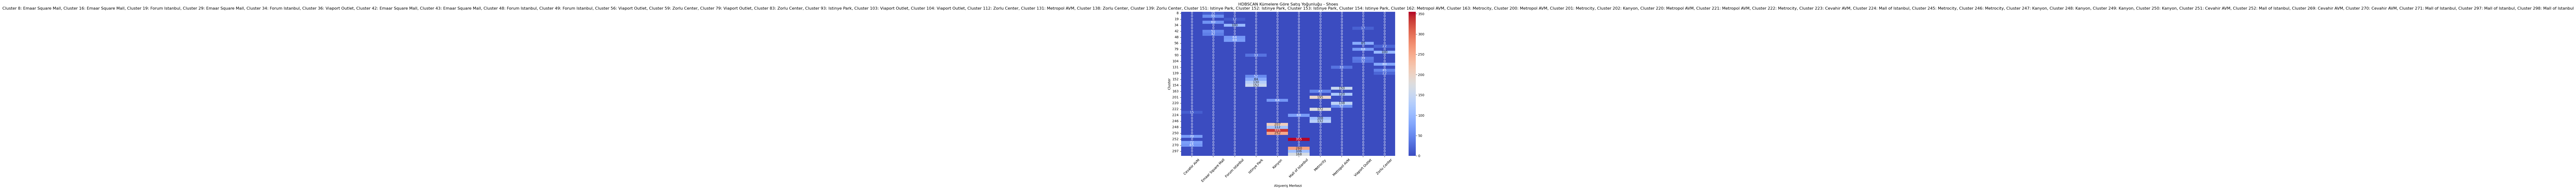

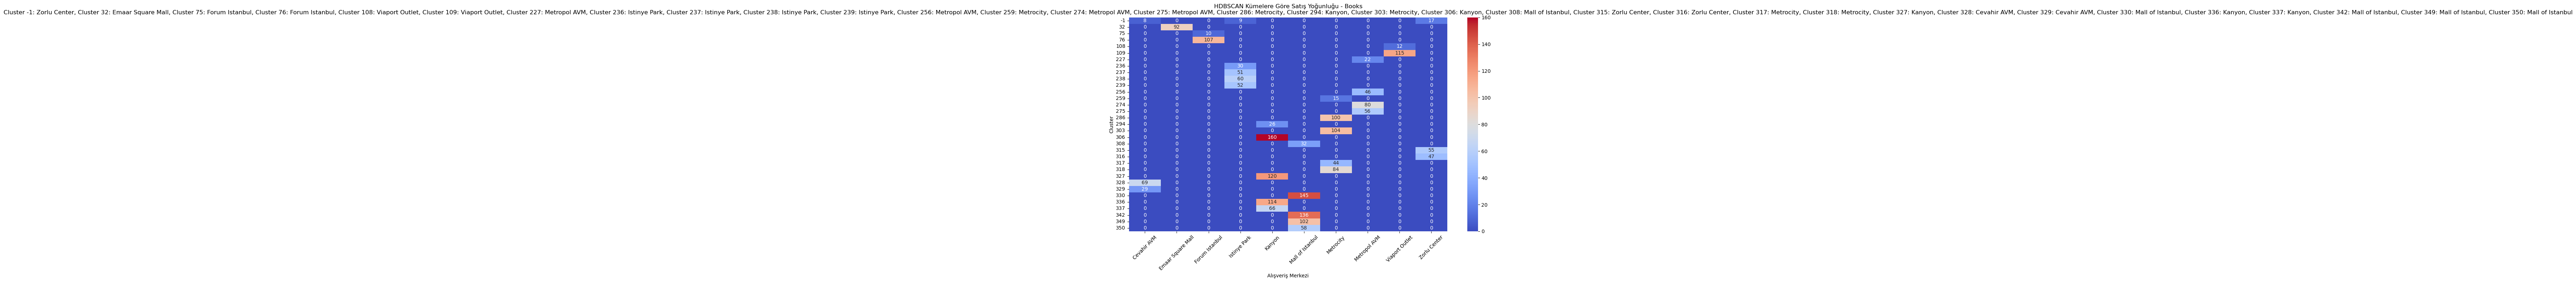

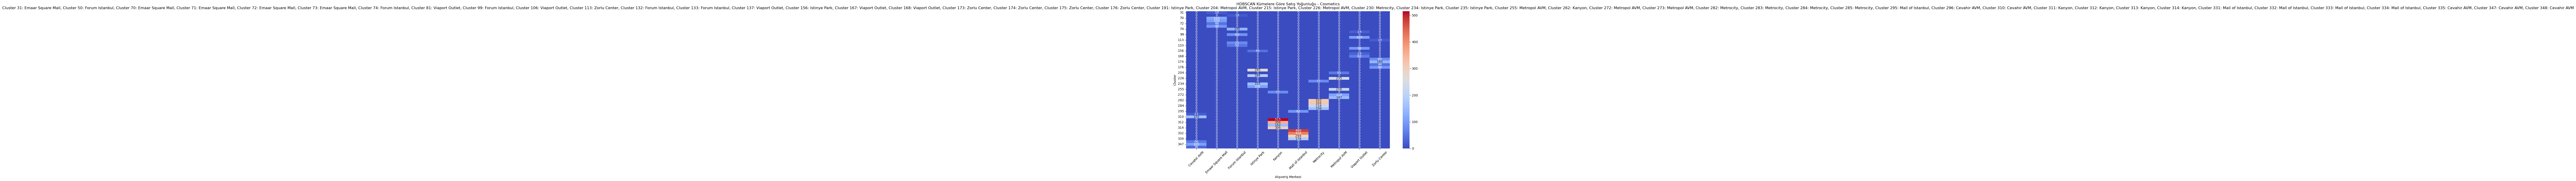

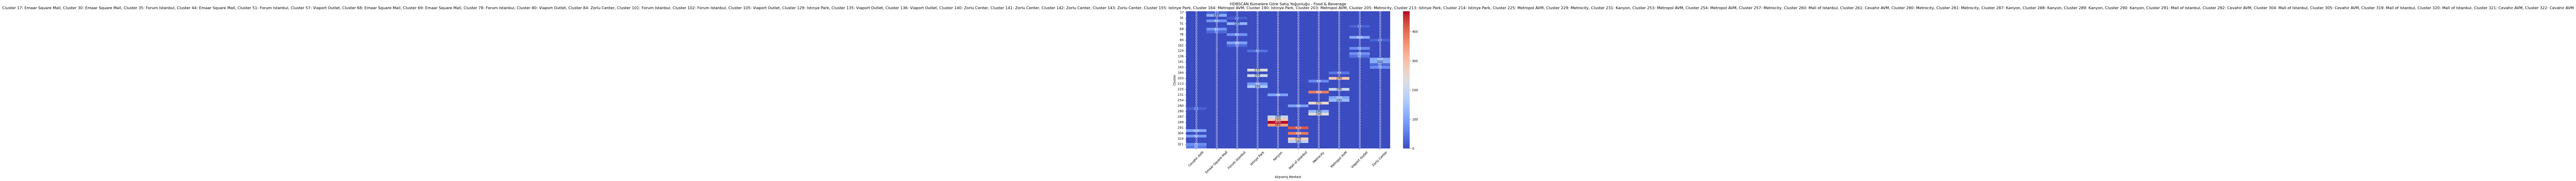

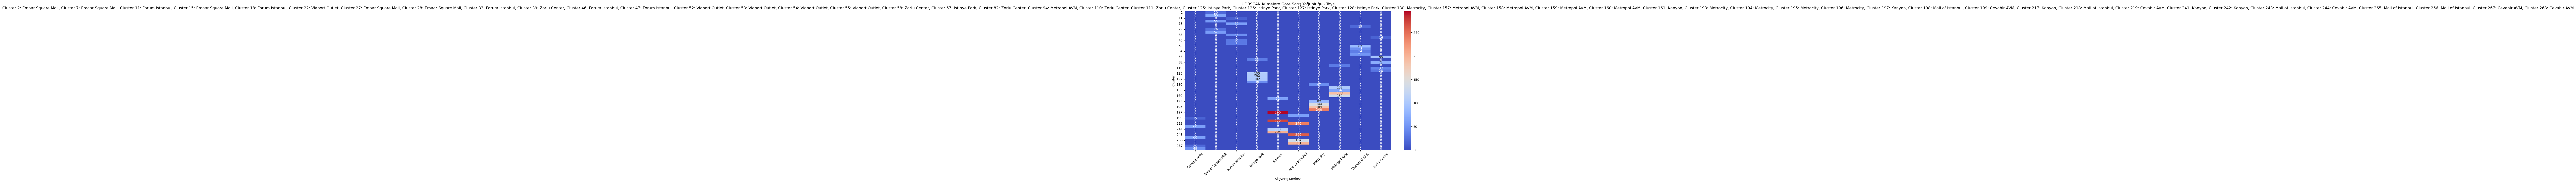

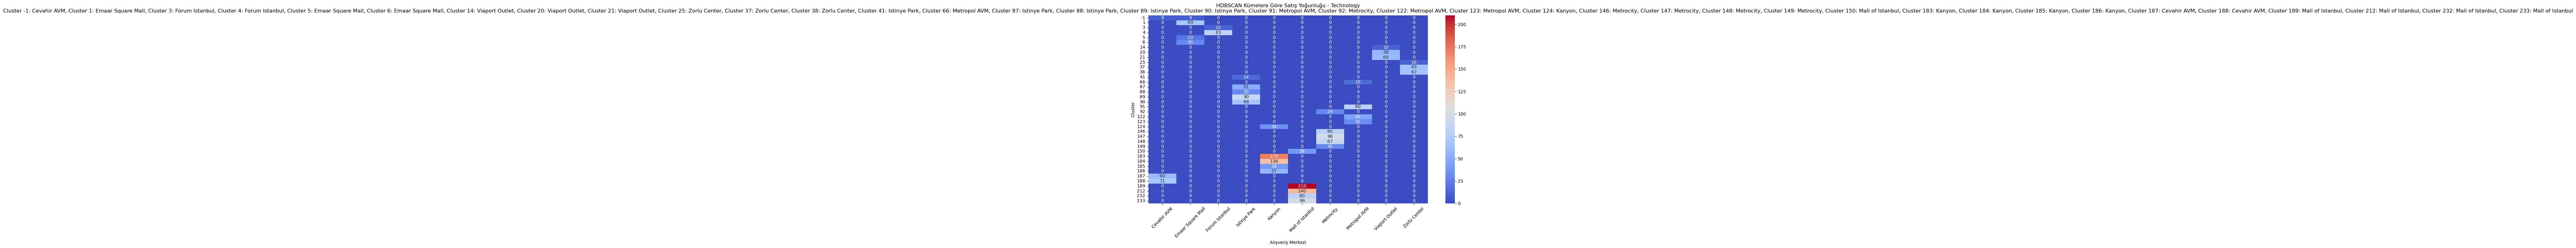

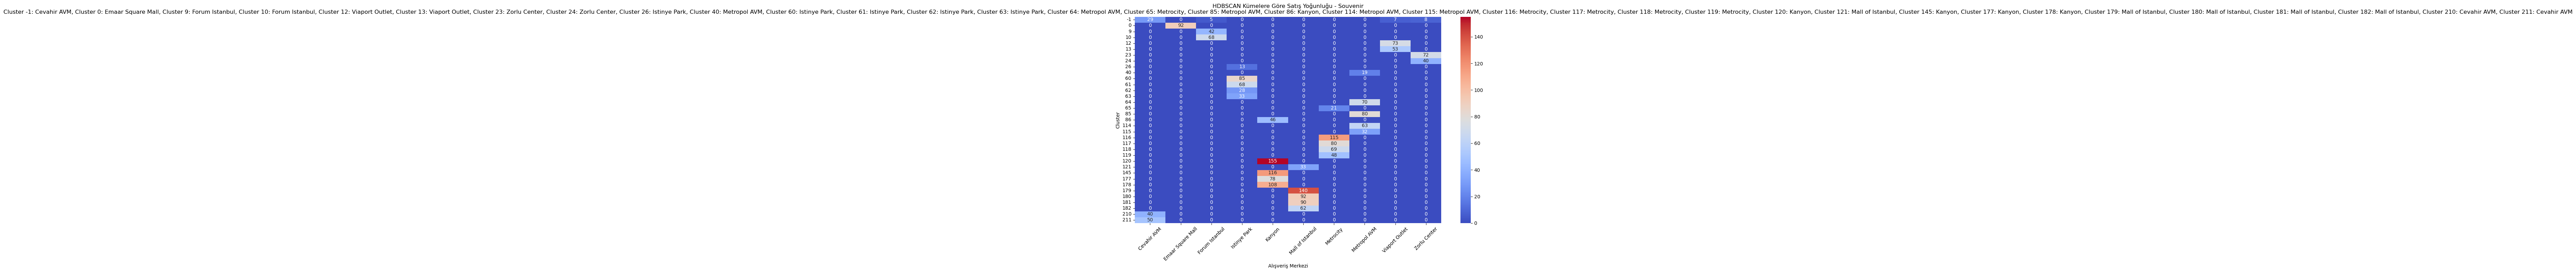

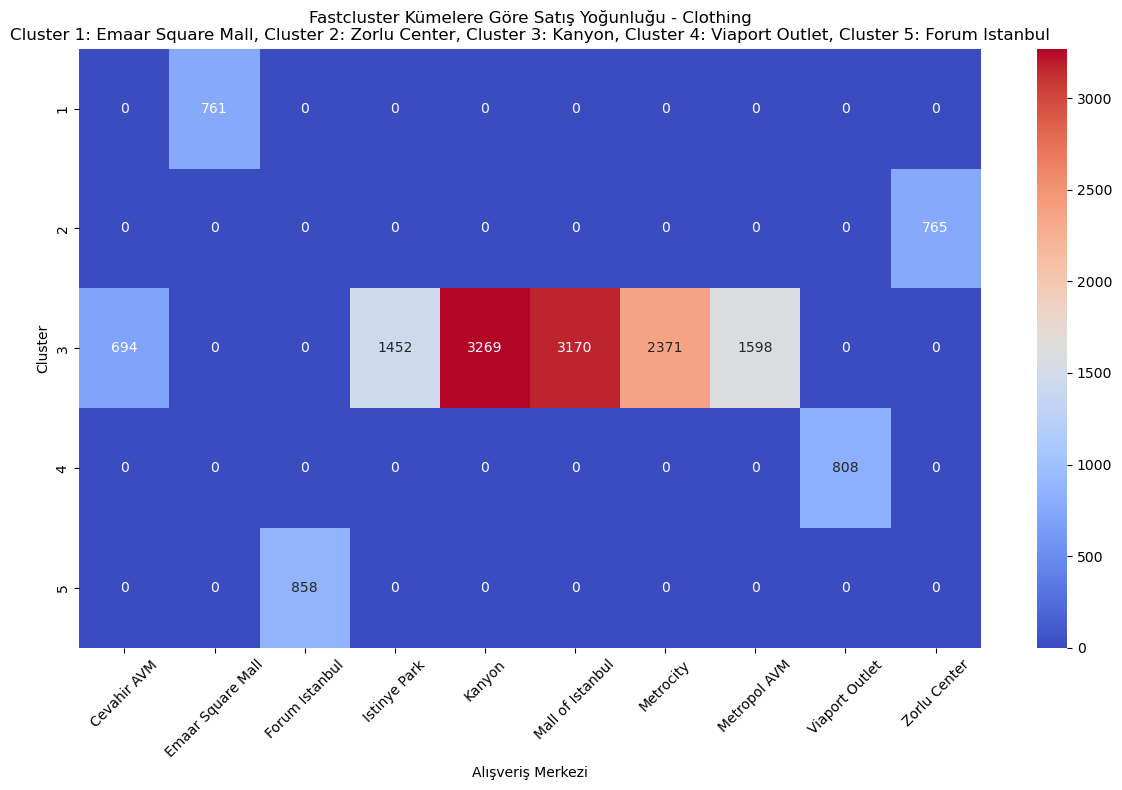

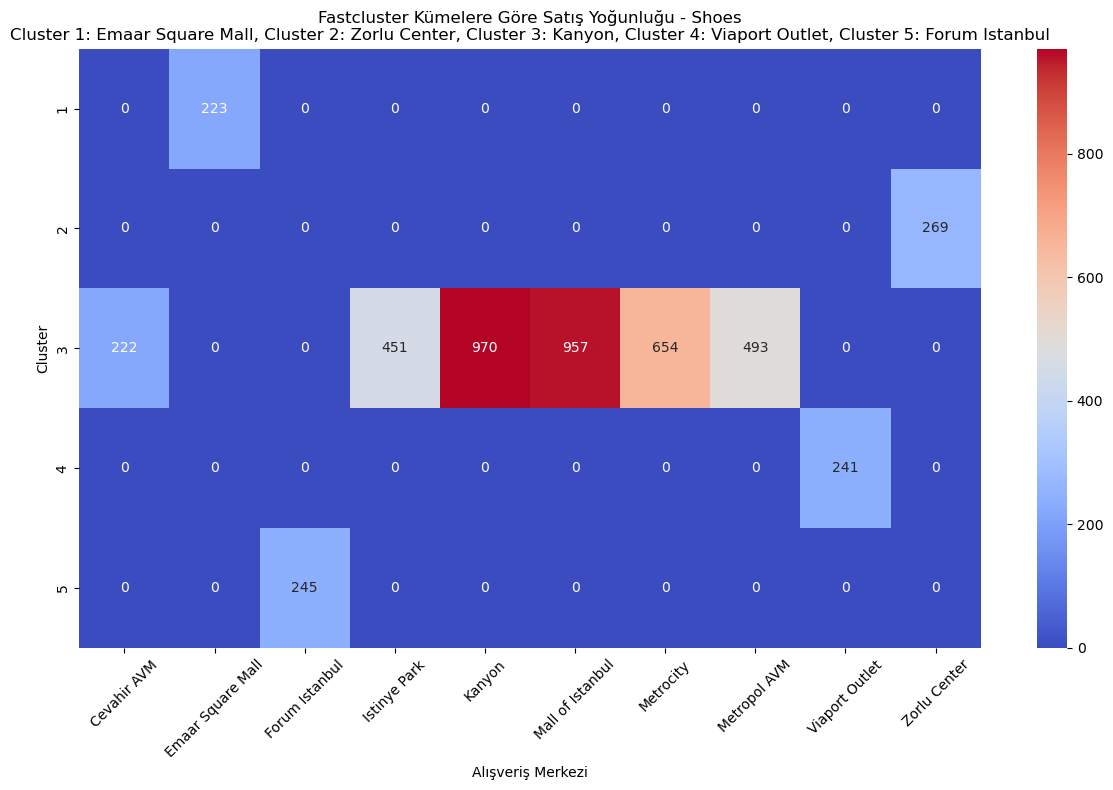

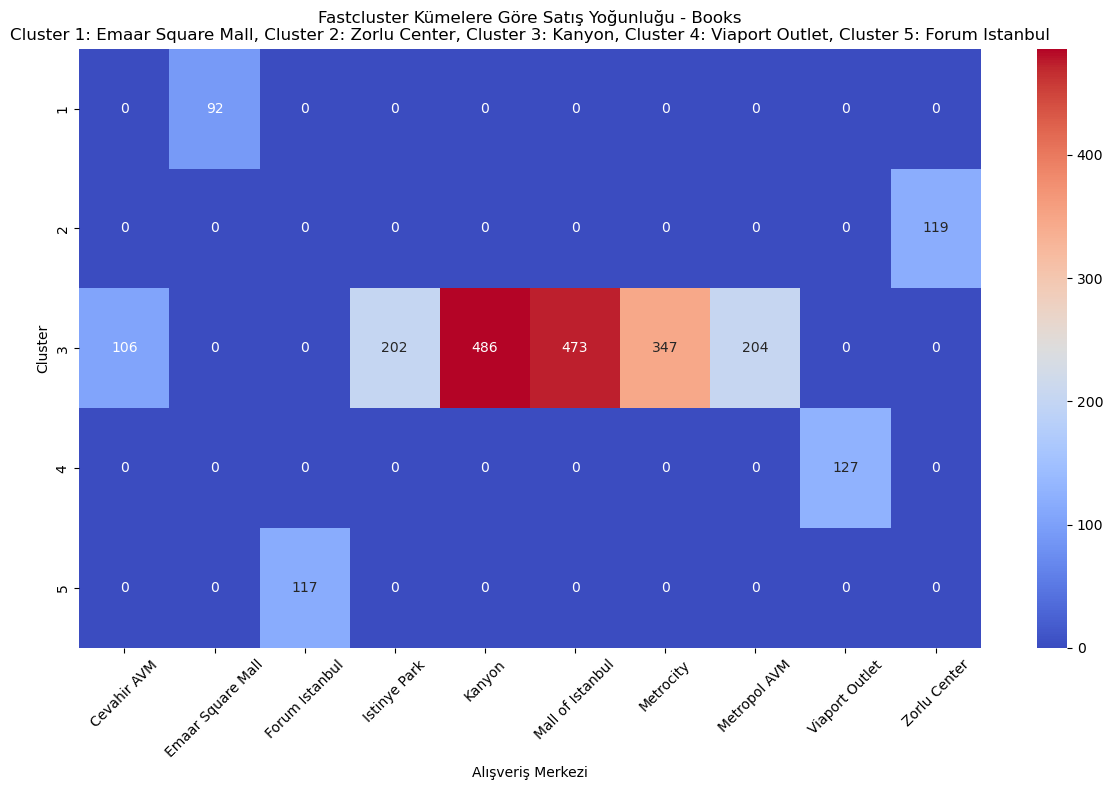

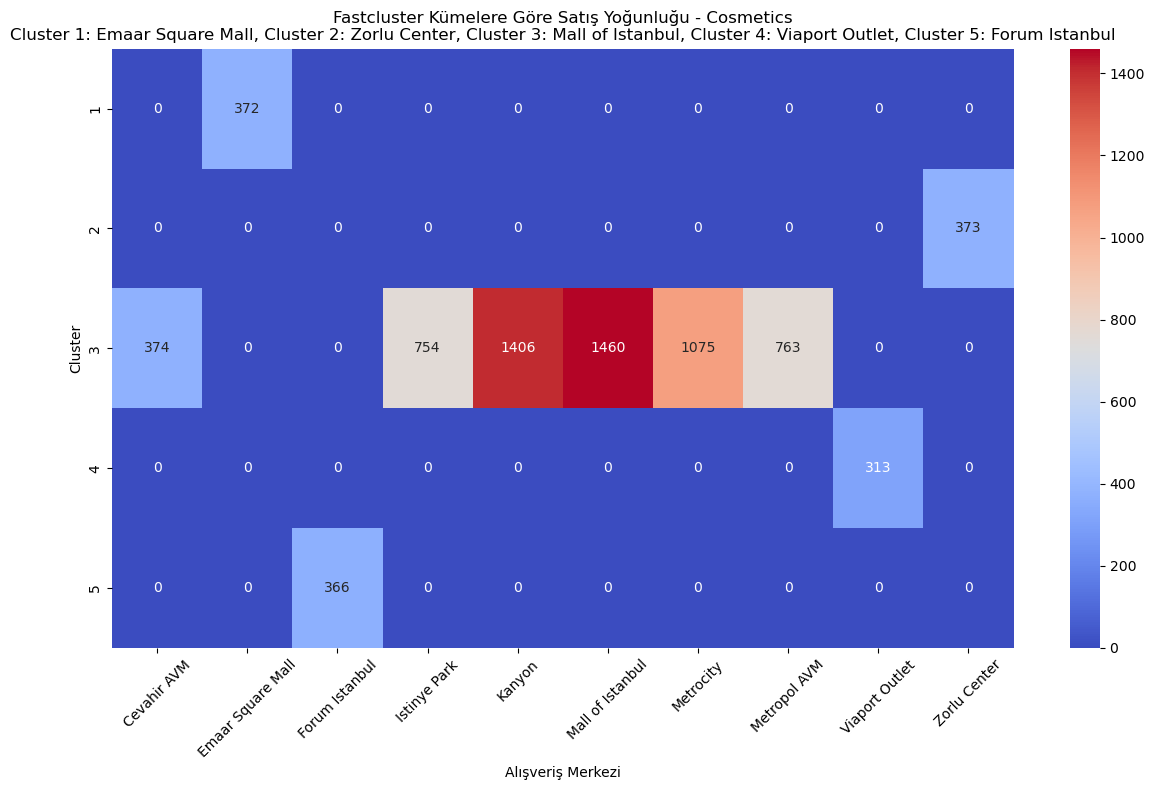

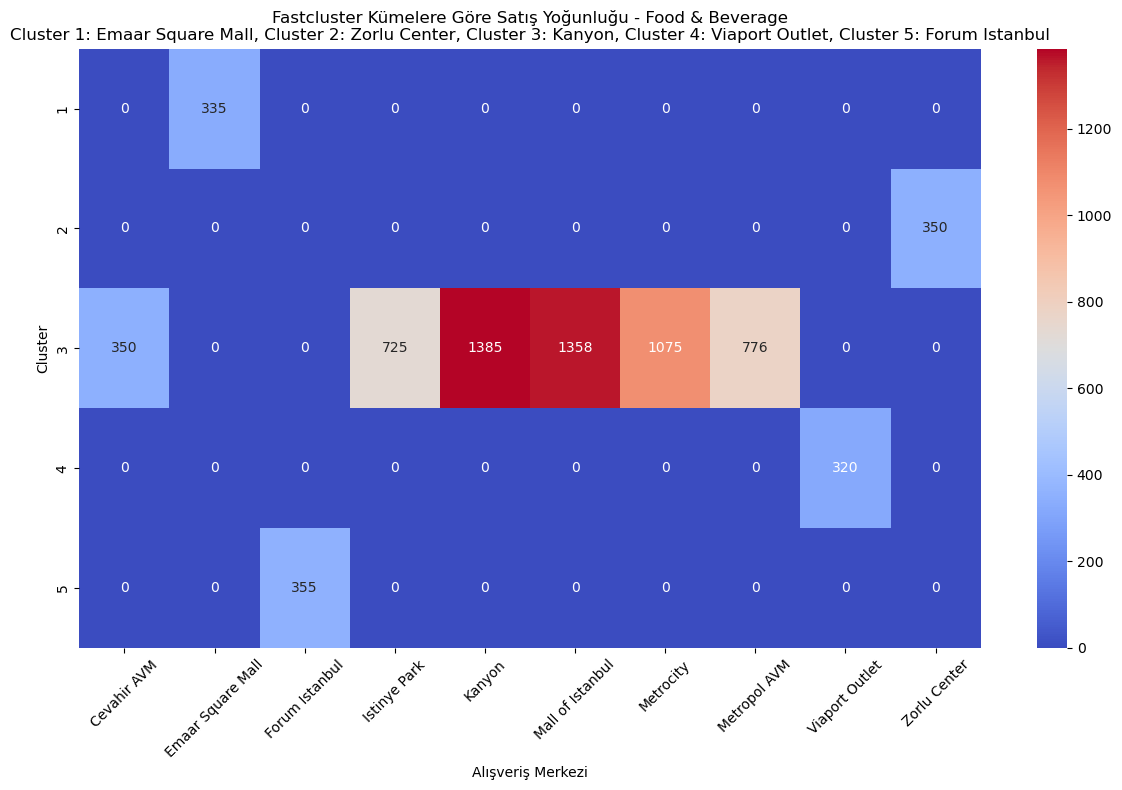

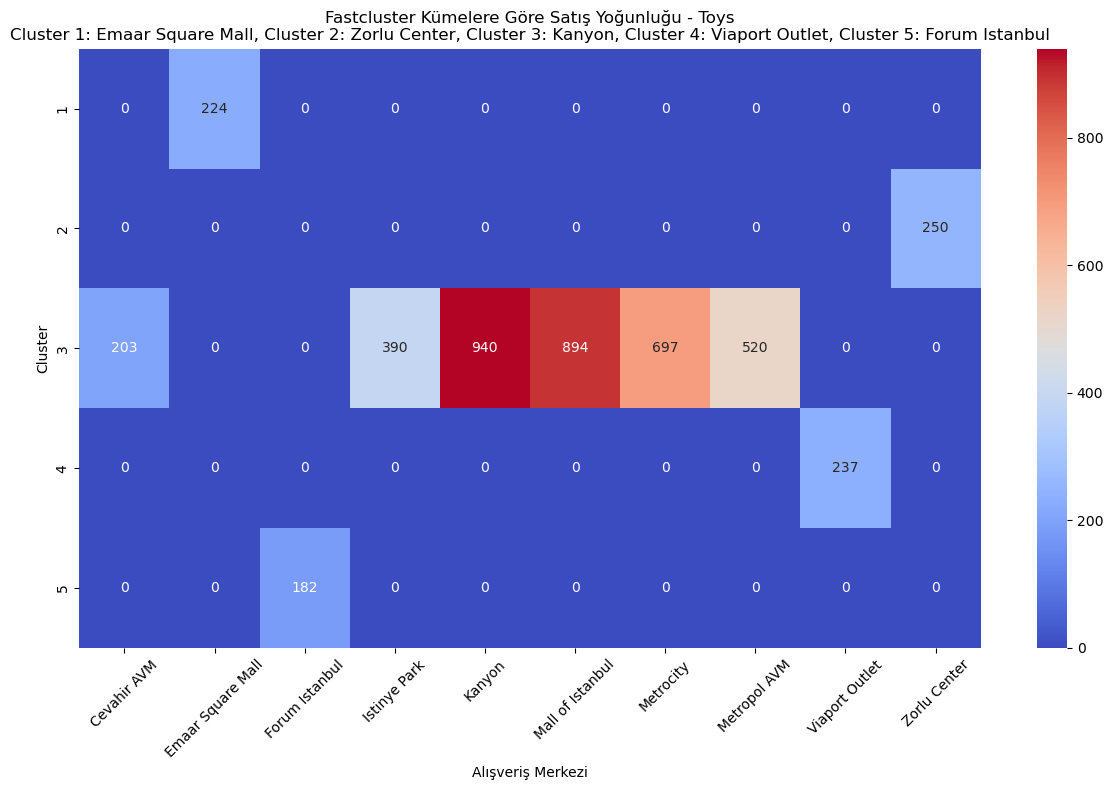

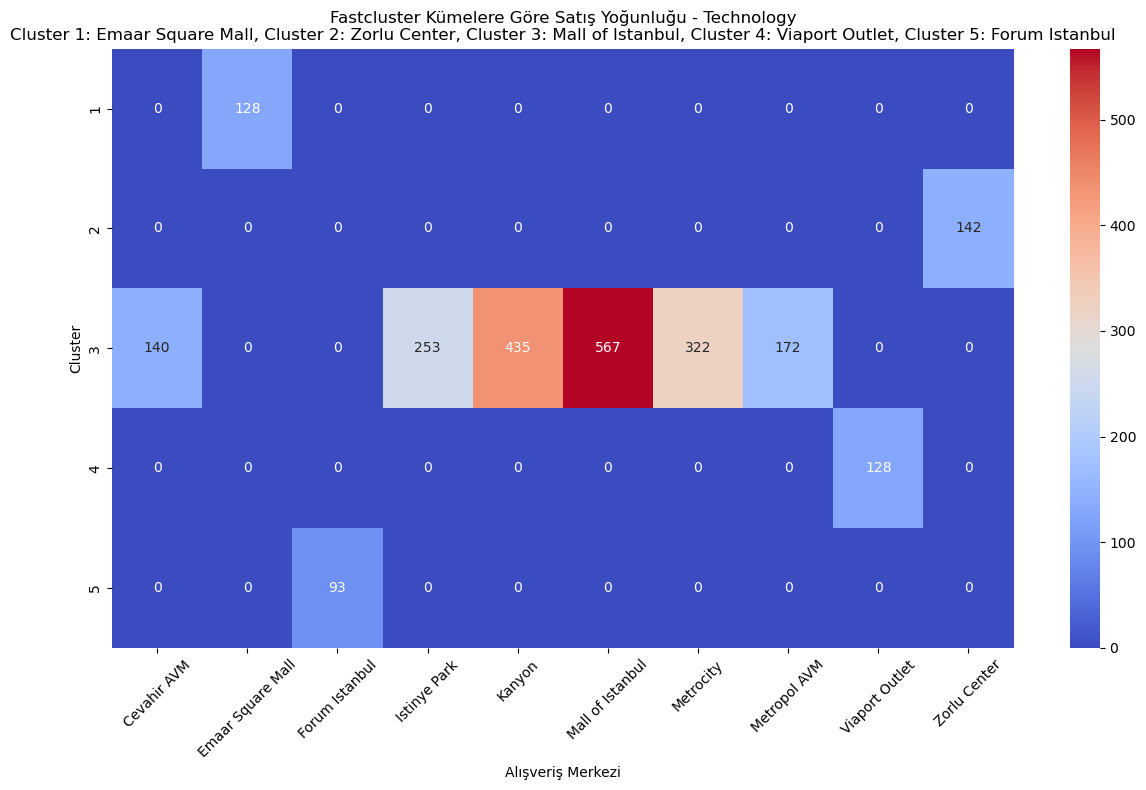

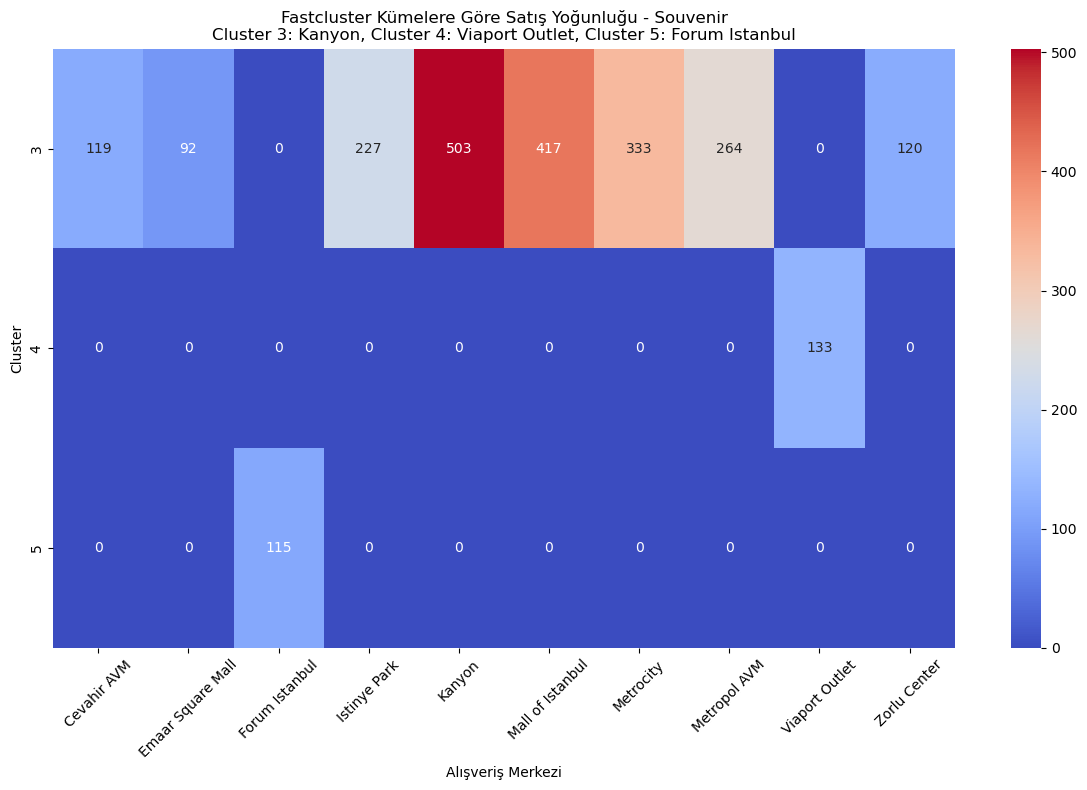

45727

In [10]:
# Algoritma bazlı satış yoğunlukları
for algorithm, labels in zip(["MiniBatch K-Means", "HDBSCAN", "Fastcluster"], [kmeans_labels, hdbscan_labels, clusters]):
    data_copy = data.copy()
    data_copy["cluster"] = labels
    for category in data["category"].unique():
        filtered_data = data_copy[data_copy["category"] == category]
        cluster_sales_heatmap = filtered_data.groupby(["cluster", "shopping_mall"]).sum()["quantity"].unstack().fillna(0)

        # Her küme için ayrı ayrı dominant alışveriş merkezi hesaplama
        dominant_malls = filtered_data.groupby("cluster").apply(
            lambda x: x.groupby("shopping_mall")["quantity"].sum().idxmax()
        )

        # Grafik çizimi
        plt.figure(figsize=(12, 8))
        sns.heatmap(cluster_sales_heatmap, annot=True, fmt=".0f", cmap="coolwarm")
        plt.title(f"{algorithm} Kümelere Göre Satış Yoğunluğu - {category}\n"
                  + ", ".join([f"Cluster {cluster}: {mall}" for cluster, mall in dominant_malls.items()]))
        plt.xlabel("Alışveriş Merkezi")
        plt.ylabel("Cluster")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

plt.show(block=True)  # Matplotlib etkileşimi aktif hale getirme

# Belleği temizleme
gc.collect()